<a href="https://colab.research.google.com/github/jufabeck2202/KI-Lab/blob/main/Termin3_WS2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Matrixfaktorisierung

In [1]:
from scipy import sparse as sp
import pandas as pd
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt

In [2]:
TOP_MOVIES = 100
RANDOM_VIEWERS = 1000
reduced = np.load('netflix_reduced.npy')
headers = []
with open('netflix_headers.txt','r') as fi:
    for line in fi.readlines():
        headers.append(line.strip().split(',')[2])

In [19]:
DATASET = 1
VERBOSE = False #False
ITERATIONS = 100
def setup():
    global R,W,P,Q,ri,ci,k,m,n
    if DATASET == 0:
        R = [[5,4,0],
             [5,5,1],
             [1,0,5],
             [1,1,4]]
        R = np.array(R,dtype=np.float64)
        k=1
    elif DATASET == 1:
        R = reduced
        k = 10
    else:
        assert(False)

    W = R > 0
    m,n = R.shape
    R = (R-3)/2
    vecr = R[W]
    np.random.seed(42)
    P = np.random.rand(m,k)
    Q = np.random.rand(n,k)
def log(text):
    if VERBOSE:
        print(text)

# Einleitung

Sei $m$ die Anzahl der User und $n$ die Anzahl der Filme. Die Bewertungen der User für die Filme ist in zwei Matrizen $W$ und $R$ kodiert. $W \in \{0,1\}^{m \times n}$ ist eine Binärmaske, welche den Eintrag $1$ in einer Zeile $i$ und Spalte $j$ besitzt, falls der User mit dem Index $i$ eine Bewertung für den Film mit dem Index $j$ abgegeben hat. Der Eintrag ist $0$, falls dieser User diesen Film nicht bewertet hat. Sei $z$ die Anzahl der Einsen von $W$. 
Die Bewertungsmatrix $R \in [-1,1]^{m \times n}$ selbst beinhaltet die Bewertung des Films in Form einen Scores. Das Interval $[-1,1]$ wird als $[\text{gefällt nicht},\text{gefällt}]$ interpretiert. 

Existierende Filmbewertungen können Sie mit der plt.spy Funktion einsehen.

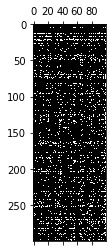

In [20]:
setup()
plt.spy(W)

Eine Auswahl an Filmen finden Sie hier:

In [ ]:
headers

Ziel der heutigen Aufgabe ist die Prädiktion der fehlenden Einträge in der Bewertungsmatrix $M$. Diese Prädiktionen könnten in einem Recommender-System genutzt werden, um einem User einer Platform einen Film vorzuschlagen.

Eine Möglichkeit bietet die Matrixfaktorisierung. Dabei wird versucht, zwei schlanke Faktoren $P \in \mathbb{R}^{m \times r}$ und $Q \in \mathbb{R}^{n \times k}$ zu finden mit $k \ll n$ und $k \ll m$, welche die Matrix $R$ so gut wie möglich rekonstruieren und zusätzlich neue Bewertungen prädizieren.
Implementieren Sie eine Funktion $f:\mathbb{R}^{m \times k} \times \mathbb{R}^{n \times k} \rightarrow \mathbb{R}^z$ mit

$f(P,Q) = (PQ^T - R)[W]$

wobei [W] hier als Indizierung zu verstehen ist. [W] extrahiert alle Residuen an den Stellen an denen $W$ den Eintrag $1$ hat. Alle $z$ Einträge werden Zeilenweise aufgesammelt und zu einem Vektor zusammengefasst. Anschließend können Sie die Kostenfunktion $e:f:\mathbb{R}^{m \times k} \times \mathbb{R}^{n \times k} \rightarrow \mathbb{R}$ berechnen durch

$e(P,Q) = \frac{1}{2}||f(P,Q)||_2^2 = \frac{1}{2}f^Tf$.

Die Funktion $f$ liefert sog. Residuen zurück, dh. sie beinhaltet die Abweichung der prädizierten Bewertungen von den tatsächlichen Berwertungen.

In [26]:
def f(_P,_Q):
    prod = _P.dot(_Q.T)
    difference = prod - R
    return difference[W]   

def e(_P,_Q):
    res1 = f(_P,_Q)
    result = res1.T.dot(res1)
    return result/2

e(P,Q)

71427.85626709972

# Solver Implementierung
## ALS-Solver
Implementieren Sie den in der Vorlesung vorgestellten "alternating least-squares" (ALS)-Solver indem Sie $P$ und $Q$ alternierend anpassen um die Kosten $e$ zu minimieren. Die Parameter und Rückgabewerte der zu implementierenden Funktionen können Sie dem Funktionsaufruf weiter unten entnehmen.

In [54]:
def solveBlockP(_P,_Q,user_idx):
    multiplier = _Q[user_idx].dot(_Q[user_idx].T)
    multiplier = 1/multiplier

    vect = np.zeros([10])
    for i in range(n):
        vect += _Q[i]*R[i][user_idx]

    return multiplier * vect

def solveBlockQ(_P,_Q,movie_idx):
    pass
setup()
solveBlockP(P,Q,0)
#solveBlockQ(P,Q,0)


array([ 1.16911204,  1.15637206,  0.80016514,  0.73229086,  0.50191778,
        1.23935008,  1.00970873,  1.1012457 , -0.1032358 ,  1.24496287])

Testen Sie Ihre Implementierung und starten Sie den ALS-Solver.

In [31]:
setup()
print(f"Error ALS before optimization: {e(P,Q)}")
for iteration in range(ITERATIONS):
    for user in range(m):
        P[user] = solveBlockP(P,Q,user)
    log(f"Cost after update P: {e(P,Q)}")
    for movie in range(n):
        Q[movie] = solveBlockQ(P,Q,movie)
    log(f"Cost after update Q: {e(P,Q)}")
print(f"Error ALS after optimization: {e(P,Q)}")

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
 0.13065234 0.79050979 0.12482081 0.79421066]
[0.27576757 0.87709058 0.94404209 0.14879597 0.46267561 0.98098738
 0.48340744 0.86354752 0.58873152 0.37532991]
[0.28578356 0.20322309 0.76179819 0.38654051 0.51127546 0.49232548
 0.57727903 0.86557715 0.98073934 0.40758421]
[0.82751892 0.76452779 0.57352895 0.95604714 0.20047452 0.10926421
 0.85396197 0.43914982 0.84696885 0.89309021]
[0.06245759 0.88346476 0.44831906 0.51043249 0.62659251 0.92638261
 0.01911609 0.47684347 0.68772204 0.72270696]
[0.69253243 0.13443513 0.29939559 0.35871553 0.80443721 0.27875987
 0.21070496 0.95744802 0.00886329 0.99782086]
[0.6768213  0.8284693  0.2946194  0.01431528 0.73786952 0.8341446
 0.74047613 0.14285029 0.75342792 0.76892278]
[0.65854052 0.76611593 0.84592144 0.61360411 0.08860471 0.48762781
 0.07764933 0.40754303 0.40710649 0.06600984]
[0.34882053 0.1109981  0.80823521 0.94768803 0.07231648 0.95511521
 0.5225766  0.29956568 0.07686

KeyboardInterrupt: ignored